#### 1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

Датасет "Productivity Prediction of Garment Employees Data Set" https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees

- 01 date : Date in MM-DD-YYYY
- 02 day : Day of the Week
- 03 quarter : A portion of the month. A month was divided into four quarters
- 04 department : Associated department with the instance
- 05 team_no : Associated team number with the instance
- 06 no_of_workers : Number of workers in each team
- 07 no_of_style_change : Number of changes in the style of a particular product
- 08 targeted_productivity : Targeted productivity set by the Authority for each team for each day.
- 09 smv : Standard Minute Value, it is the allocated time for a task
- 10 wip : Work in progress. Includes the number of unfinished items for products
- 11 over_time : Represents the amount of overtime by each team in minutes
- 12 incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
- 13 idle_time : The amount of time when the production was interrupted due to several reasons
- 14 idle_men : The number of workers who were idle due to production interruption
- 15 actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1.

Целевая переменная - actual_productivity, изменяется в диапазоне от 0 до 1. Чтобы превратить задачу в бинарную классификацию, отметим "0" тех сотрудников, которые справились с целью по продуктивности (targeted_productivity). Тех, кто не справился, отметим 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.simplefilter('ignore')
from time import strptime
import xgboost
import shap

In [17]:
df = pd.read_csv('C:/Users/yana/2/garments_worker_productivity.csv')
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [18]:
df['actual_productivity'] = np.where(df['actual_productivity'] >=df['targeted_productivity'], 0, 1)

#### 2. сделать обзорный анализ выбранного датасета

In [19]:
#посмотрим пропуски
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

In [20]:
#посмотрим типы данных
df.dtypes

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity        int32
dtype: object

In [21]:
df['actual_productivity'].value_counts(normalize=True) # распределение дисбалансное, но не самое плохое 

0    0.730994
1    0.269006
Name: actual_productivity, dtype: float64

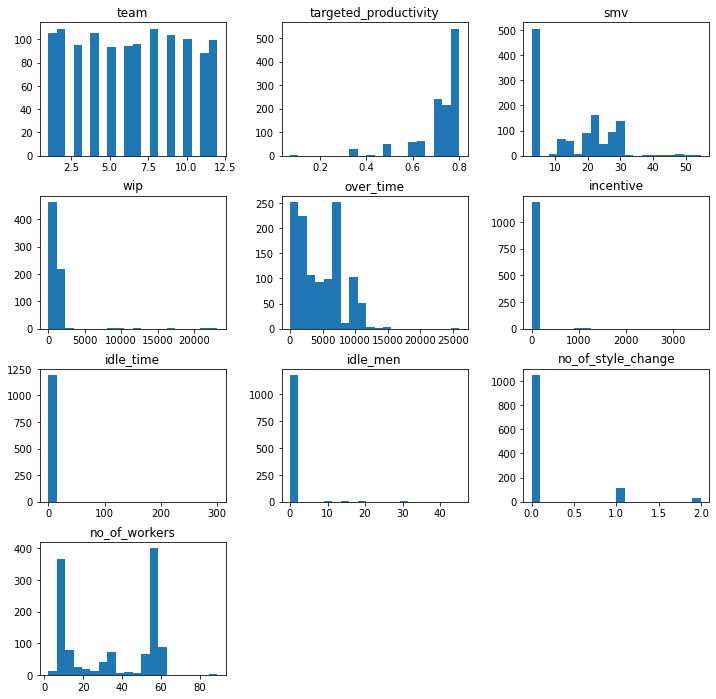

In [22]:
num_features = df.select_dtypes(exclude=['object'])
num_features.drop(['actual_productivity'], axis=1, inplace=True)
num_features.hist(figsize=(12,12), bins=20, grid=False);

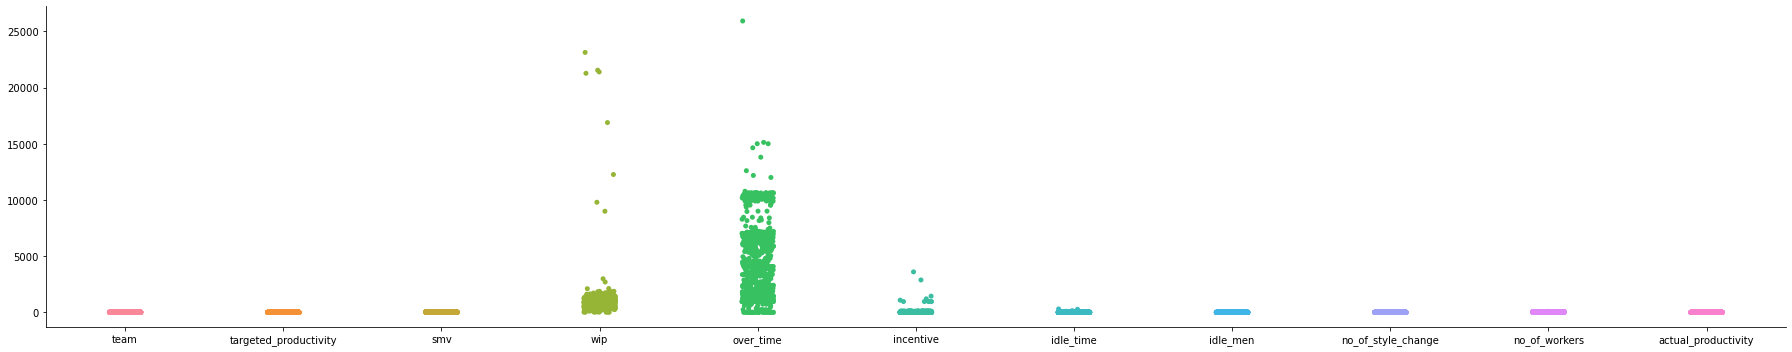

In [23]:
sns.catplot(data = df, height = 5, aspect = 5)

распределения не являются нормальными, возможны выбросы в "over_time" и "incentive", но без контекста не понятно, выбросы это или действительно такие аномальные случаи. Не будем считать их выбросами в данной работе, потому что большинство значений по данным признакам равны 0, а те, что отличны от нуля, распределяются крайне неравномерно

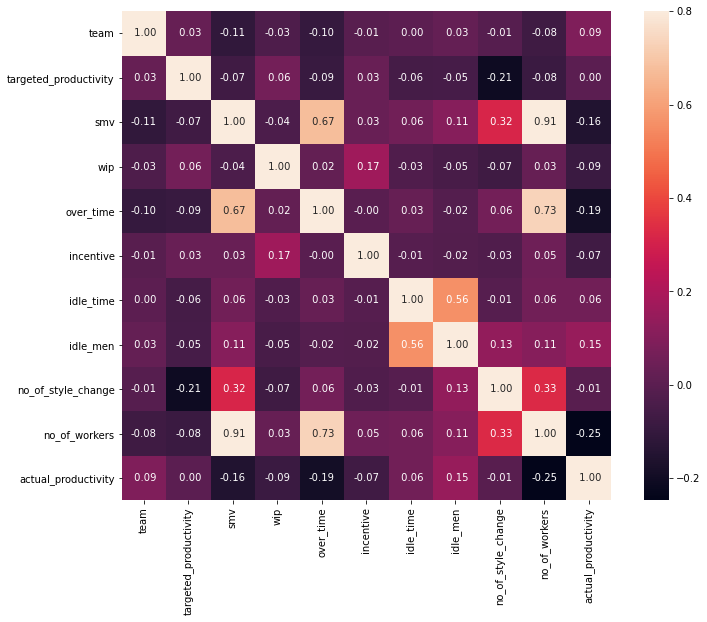

In [24]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df.corr(), vmax=.8, annot=True, fmt=' .2f', square=True);

#### 3. сделать feature engineering

In [25]:
class Dataset:
    
    def __init__(self):
        self.median_wip=None
        
    def fit(self, df):
        self.median_wip = df['wip'].median()

        
    def transform(self, df):
        df['wip'].fillna(self.median_wip,inplace=True)
        df['date'] = (pd.to_datetime(df['date']) - pd.Timestamp('2014-12-31')) // pd.Timedelta('1d')
        df['quarter'] = np.array([int(i[-1]) for i in df['quarter']])
        df['quarter'] = df['quarter'].astype('int8')
        df['day'] = [(strptime(i,'%A').tm_wday) for i in df['day']]
        df.loc[df['department'] =='finishing ', 'department'] = 'finishing'
        df['department'] = np.where(df['department']=='finishing', 1, 0)
        
        
        return df

In [26]:
data = Dataset()
data.fit(df)
df = data.transform(df)

#### 4. обучить любой классификатор (какой вам нравится)

In [27]:
x_data = df.drop(['actual_productivity'], axis=1, inplace=False)
y_data = df['actual_productivity']
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=7)

In [28]:
xgb_model = xgboost.XGBClassifier(colsample_bytree=0.4, objective='binary:logistic',
                 eta = 0.1,                                   
                 learning_rate=0.03,
                 max_depth=4,
                 min_child_weight=2,
                 n_estimators=210,                                                                    
                 reg_alpha=0.6,
                 reg_lambda=0.3,
                 subsample=0.8,
                 seed=21)
xgb_model.fit(X_train, y_train)
y_predict = xgb_model.predict(X_test)

In [29]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    return f1, roc, rec, prc

    
f1, roc, rec, prc = evaluate_results(y_test, y_predict)

Classification results:
f1: 69.51%
roc: 79.53%
recall: 67.06%
precision: 72.15%


#### 5. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%

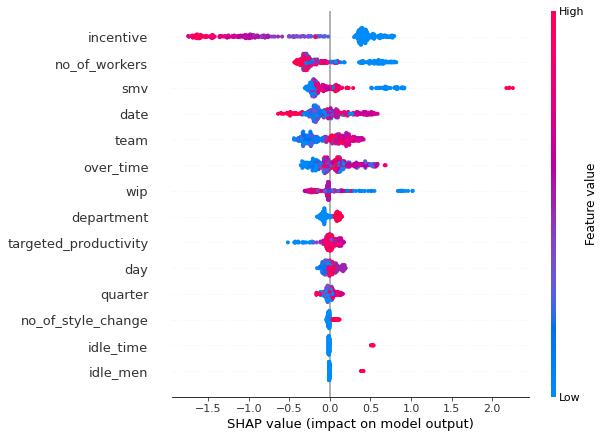

In [30]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

- incentive: чем выше уровень финансовой поддержки, тем выше продуктивность сотрудников. По утолщению голубой линии справа от центральной черты видно, что по многим проектам с низкой финансовой поддержкой продуктивность низкая
- no_of_workers: если мало сотрудников в команде, целевая продуктивность, как правило, не достигается
- date: ближе к концу года сотрудники случше справляются с планом по продуктивности
- department finishing не справляется с целевой продуктивностью
- targeted_productivity: если запланирована низкая продуктивность, обычно с поставленной целью сотрудники справляются
- work in progress: если низкое кол-во объектов, с которыми уже начата работа, с поставленной задачей по продуктивности часто не справляются
- idle_men и idle_time: чем больше время простоя и чем больше сотрудников вынуждены сидеть без работы, там хуже выполняется план по продуктивности

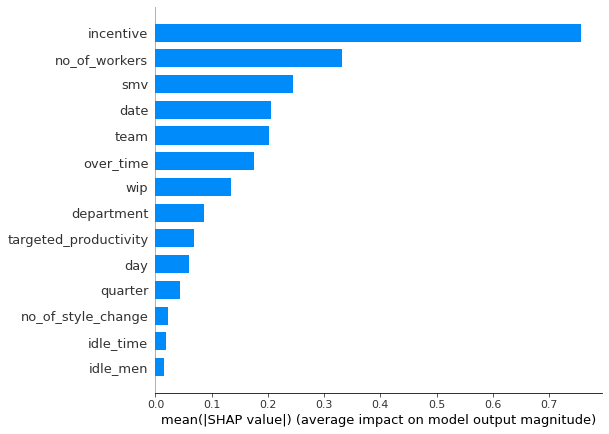

In [31]:
# feature importance plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

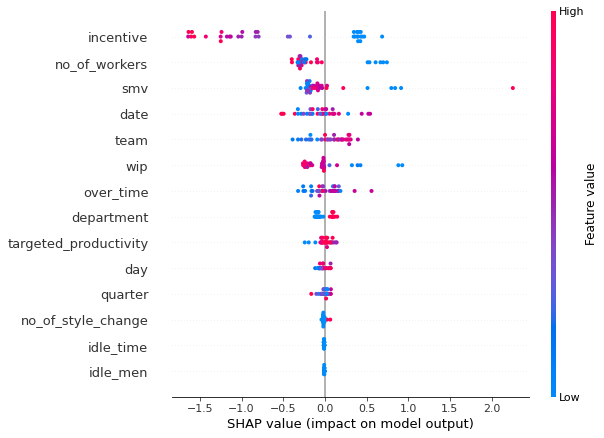

In [32]:
n = X_test.shape[0]//10
shap.initjs() 
shap.summary_plot(shap_values[:n,:], X_test.iloc[:n,:])

#### 6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [33]:
X_test.head(5)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
657,39,2,0,6,10,0.8,22.52,1388.0,6720,88,0.0,0,0,56.0
98,6,1,0,1,6,0.8,11.61,910.0,4470,38,0.0,0,0,31.5
63,5,1,1,0,4,0.8,3.94,1039.0,3840,0,0.0,0,0,16.0
905,55,4,0,1,12,0.8,15.26,1062.0,4080,50,0.0,0,0,34.0
782,46,3,0,6,2,0.8,22.52,12.0,6900,0,0.0,0,0,57.5


In [34]:
n=0
shap.initjs() # для работы в колаборатории 
shap.force_plot(explainer.expected_value, shap_values[n,:], X_test.iloc[n,:])

Наблюдение будет отмечено классом "0", т.к. оценка модели ниже бэйслайна. Самый влиятельный признак здесь - incentive, равен 88, что повышает вероятность отнесения к классу "0"; в команде 56 сотрудников, что тоже значительно влияет на понижение скора и отнесение наблюдения к классу "0". Напротив, скор за отнесение к классу "1" растет из-за team = 10 (команда № 10) и овертайма = 6720. Но признаки за отнесение к классу "0" более влиятельны

In [35]:
n=1
shap.initjs() # для работы в колаборатории 
shap.force_plot(explainer.expected_value, shap_values[n,:], X_test.iloc[n,:])

Наблюдение будет отмечено классом "0", т.к. оценка модели ниже бэйслайна. Практически все признаки говорят о том, что модель нужно отнести к нулевому классу: incentive=38, no_of_workers=31.5 (округление кол-ва сотрудников до целых негативно сказалось на результатах модели. Может, сотрудник работал на пол-ставки, поэтому их 31 с половиной). Вес признаков за отнесение к классу "1" совсем незначительный

In [36]:
n=4
shap.initjs() # для работы в колаборатории 
shap.force_plot(explainer.expected_value, shap_values[n,:], X_test.iloc[n,:])

На 5й строке наблюдение, которое будет отмечено классом "1", скор выше бэйслайна. Самые влиятельные признаки в пользу класса "1": wip = 12, incentive=0, over_time = 6900. За нулевой класс признаки team=2 и большое кол-во сотрудников, но их суммарное значение гораздо меньше, чем значения в пользу класса "1"